# Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
hotels = pd.read_csv('hotels.csv')
searches = pd.read_csv('searches.csv')
td = pd.read_csv('train.csv')

In [3]:
clicked_hotels = td[["prop_id", "site_id", "prop_country_id", "click_bool", "booking_bool"]]
clicked_hotels["click_count"] = clicked_hotels["prop_id"].map(clicked_hotels["prop_id"].value_counts())
clicked_hotels.drop("click_bool", axis=1, inplace=True)
clicked_hotels_deneme = clicked_hotels.groupby("prop_country_id")["click_count"].sum()
click_book = clicked_hotels.groupby("prop_id")["booking_bool"].sum()
click_book = pd.DataFrame(click_book).reset_index().rename(columns={"booking_bool" : "sum_booking"})
clicked_hotels_deneme = pd.DataFrame(clicked_hotels_deneme).reset_index()
clicked_hotels = pd.merge(click_book, clicked_hotels, on="prop_id")
clicked_hotels = pd.merge(clicked_hotels_deneme, clicked_hotels, on="prop_country_id")
clicked_hotels["click_interaction"] = clicked_hotels["click_count_y"] / clicked_hotels["click_count_x"] * 10
clicked_hotels.drop(['click_count_x', 'click_count_y', 'site_id', "prop_country_id", "booking_bool"], axis=1, inplace=True)
clicked_hotels

/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_69100/3374621306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked_hotels["click_count"] = clicked_hotels["prop_id"].map(clicked_hotels["prop_id"].value_counts())
/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_69100/3374621306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked_hotels.drop("click_bool", axis=1, inplace=True)


,prop_id,sum_booking,click_interaction
0,23513,0,0.121107
1,23513,0,0.121107
2,23513,0,0.121107
3,23513,0,0.121107
4,23513,0,0.121107
...,...,...,...
4958342,140791,0,0.000330
4958343,140791,0,0.000330
4958344,140791,0,0.000330
4958345,140791,0,0.000330


In [4]:
clicked_hotels["sum_booking"].value_counts()

sum_booking
0     1266262
1      778862
2      559403
3      393975
4      306434
       ...   
59        820
90        815
68        612
54        371
85        314
Name: count, Length: 88, dtype: int64

In [5]:
clicked_hotels["search_percentage"] = clicked_hotels["prop_id"].map(td["prop_id"].value_counts()) / len(clicked_hotels["prop_id"].unique()) * 10
clicked_hotels["sum_booking"] = clicked_hotels["sum_booking"] / 100

In [6]:
clicked_hotels = clicked_hotels.drop_duplicates()

In [7]:
book_count = hotels[["prop_id", "booked_family_count", "solo_count", "booked_couples_count"]]

# merge td and book_count
td = pd.merge(td, book_count, on='prop_id', how='left')
td = pd.merge(td, clicked_hotels, on="prop_id", how='left')

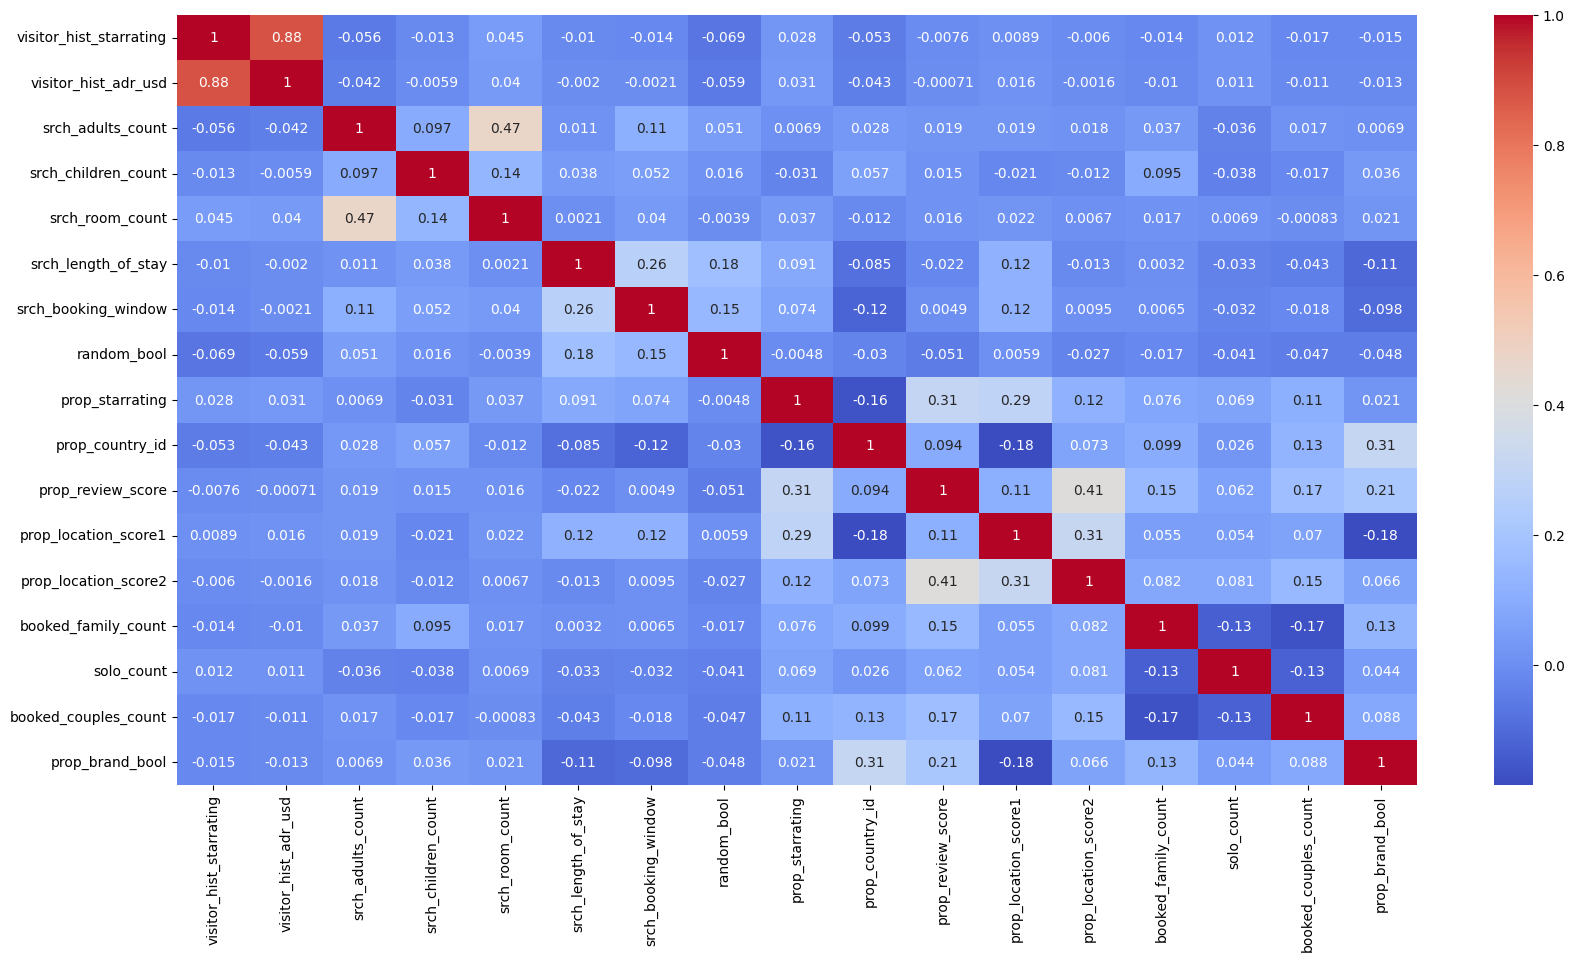

In [8]:
columns_to_include = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_length_of_stay', 'srch_booking_window', 'random_bool',
                      'prop_starrating', 'prop_country_id', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'booked_family_count', 'solo_count', 'booked_couples_count', 'prop_brand_bool']
user_data = td[columns_to_include]

# Normalize the data
normalized_data = (user_data - user_data.mean()) / user_data.std()

correlation_matrix = normalized_data.corr()

# plot correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [9]:
td.columns

Index(['Unnamed: 0', 'srch_id', 'date_time', 'site_id',
       'visitor_location_country_id', 'visitor_hist_starrating',
       'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating',
       'prop_review_score', 'prop_brand_bool', 'prop_location_score1',
       'prop_location_score2', 'prop_log_historical_price', 'position',
       'price_usd', 'promotion_flag', 'srch_destination_id',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
       'random_bool', 'click_bool', 'booking_bool', 'booked_family_count',
       'solo_count', 'booked_couples_count', 'sum_booking',
       'click_interaction', 'search_percentage'],
      dtype='object')

In [10]:
# drop Unnamed: 0 , date_time, prop_log_historical_price, srch_destination_id
td = td.drop(['Unnamed: 0', 'date_time', 'prop_log_historical_price', 'srch_destination_id'], axis=1)

In [11]:
# Define the weights for each criterion
booking_weight = 0.7
click_weight = 0.1
random_weight = 0.05
brand_weight = 0.05
prop_starrating_weight = 0.03
prop_review_score_weight = 0.03
prop_location_score1_weight = 0.01
prop_location_score2_weight = 0.01
position_weight = 0.02

# Calculate the score for each entry
td['score'] = (
    td['booking_bool'].apply(lambda x: booking_weight if x else 0) +
    td['click_bool'].apply(lambda x: click_weight if x else 0) +
    td['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
    td['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
    td['prop_starrating'] * prop_starrating_weight +
    td['prop_review_score'] * prop_review_score_weight +
    td['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
    td['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight +
    (1 / td['position']) * position_weight
)

td['rank'] = td.groupby('srch_id')['score'].rank(method='min', ascending=True)

In [30]:
td['score'] = (td['score'] * 100).astype(int)

In [12]:
# Define the weights for each criterion
sum_book = 0.5
click_interaction_weight = 0.15
search_perc_weight = 0.1
brand_weight = 0.1
prop_starrating_weight = 0.05
prop_review_score_weight = 0.05
prop_location_score1_weight = 0.025
prop_location_score2_weight = 0.025

# Calculate the score for each entry
td['test_score'] = (
    td["sum_booking"].apply(lambda x: sum_book) +
    td['search_percentage'].apply(lambda x: search_perc_weight) +
    td['click_interaction'].apply(lambda x: click_interaction_weight) +
    td['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
    td['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
    td['prop_starrating'] * prop_starrating_weight +
    td['prop_review_score'] * prop_review_score_weight +
    td['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
    td['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight
)

In [13]:
# Sort the dataset by search ID and rank
td.sort_values(['srch_id'], inplace=True)

In [14]:
# Print the dataset with the calculated score and rank
print(td[['srch_id', 'prop_id','booking_bool', 'score', 'test_score']].head(40))

    srch_id  prop_id  booking_bool     score  test_score
0         1      893             0  0.274479    1.246845
27        1   122844             0  0.298722    1.282580
26        1   114766             0  0.231758    1.165380
25        1   111106             0  0.222512    1.142427
24        1   111000             0  0.297997    1.280410
23        1   107872             0  0.244232    1.193912
22        1    97247             0  0.244070    1.196113
20        1    95166             0  0.288173    1.268647
19        1    89073             0  0.314283    1.302375
18        1    88218             0  0.306466    1.297415
17        1    88127             0  0.244494    1.184845
16        1    88096             0  0.320930    1.325150
15        1    85728             0  0.218617    1.144930
14        1    81437             0  0.284488    1.257887
21        1    95307             0  0.320149    1.287873
12        1    68914             1  1.023744    1.155515
13        1    74474           

In [15]:
td.isnull().sum()

srch_id                        0
site_id                        0
visitor_location_country_id    0
visitor_hist_starrating        0
visitor_hist_adr_usd           0
prop_country_id                0
prop_id                        0
prop_starrating                0
prop_review_score              0
prop_brand_bool                0
prop_location_score1           0
prop_location_score2           0
position                       0
price_usd                      0
promotion_flag                 0
srch_length_of_stay            0
srch_booking_window            0
srch_adults_count              0
srch_children_count            0
srch_room_count                0
srch_saturday_night_bool       0
random_bool                    0
click_bool                     0
booking_bool                   0
booked_family_count            0
solo_count                     0
booked_couples_count           0
sum_booking                    0
click_interaction              0
search_percentage              0
score     

In [31]:
td_sample = td.sample(2000000, random_state=42)
td_sample

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,booking_bool,booked_family_count,solo_count,booked_couples_count,sum_booking,click_interaction,search_percentage,score,rank,test_score
4065887,272778,18,106,0.00,-1.00,26,6351,5,4.0,1,...,0,0.500000,0.000000,0.000000,0.02,0.001732,0.001781,3300,24.0,1.345173
4669482,313261,5,219,0.00,-1.00,219,25159,4,4.0,1,...,0,0.269231,0.179487,0.423077,0.78,0.000012,0.080627,4000,15.0,1.437607
3930629,263802,5,111,0.00,-1.00,219,79338,3,4.5,0,...,0,0.125000,0.125000,0.500000,0.08,0.000004,0.024552,3200,11.0,1.269985
2432242,163360,5,219,0.00,-1.00,219,78169,4,4.5,1,...,0,0.454545,0.181818,0.272727,0.11,0.000003,0.016575,3600,21.0,1.352728
2467687,165700,15,55,0.00,-1.00,31,81134,4,4.0,0,...,0,0.500000,0.000000,0.000000,0.02,0.000096,0.005886,3600,14.0,1.382910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4533146,304103,5,219,0.00,-1.00,219,90688,2,3.0,1,...,1,0.166667,0.166667,0.666667,0.06,0.000002,0.010766,10800,32.0,1.222432
161503,10813,5,219,0.00,-1.00,219,113138,3,4.5,1,...,0,0.333333,0.111111,0.444444,0.09,0.000003,0.022074,3400,8.0,1.315253
4309516,289143,5,219,0.00,-1.00,219,68799,3,4.0,1,...,0,0.000000,0.000000,0.000000,0.00,0.000001,0.007126,3400,24.0,1.329135
1123702,75029,5,219,0.00,-1.00,219,67282,3,4.5,1,...,0,0.500000,0.500000,0.000000,0.02,0.000003,0.017117,3400,12.0,1.323773


In [33]:
features = ['prop_starrating',
       'prop_review_score', 'prop_location_score1',
       'prop_location_score2',
       'price_usd','test_score',
       'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
       'srch_children_count', 'srch_room_count']

X = td[features]
y = td['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=20)

# Train the classifier
knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# test_df["rank"] = y_pred

KNeighborsClassifier(n_neighbors=20)

In [18]:
# prepare test set
test_df = pd.read_csv('files/test_set_VU_DM.csv')

test_df = test_df.dropna(thresh=test_df.shape[0]*0.5,axis=1)
test_df = test_df.drop(['orig_destination_distance'], axis=1)

In [19]:
test_df = pd.merge(test_df, clicked_hotels, on="prop_id", how='left')

In [20]:
null_score = test_df[test_df["prop_location_score2"].isnull()]["prop_id"]

# get rows where prop_location_score2 is not null
not_null_score = test_df[test_df["prop_location_score2"].notnull()][["prop_id", "prop_location_score2"]]

# get mean of prop_location_score2 for each prop_id
mean_score = not_null_score.groupby("prop_id").mean()
mean_dict = mean_score.to_dict()["prop_location_score2"]

# fill null values with mean
test_df.loc[test_df["prop_location_score2"].isnull(), "prop_location_score2"] = test_df[test_df["prop_location_score2"].isnull()]["prop_id"].map(mean_dict)

In [21]:
test_df["prop_location_score2"].fillna(-1, inplace=True)
test_df["prop_review_score"].fillna(0, inplace=True)
test_df["sum_booking"].fillna(0, inplace=True)
test_df["click_interaction"].fillna(0, inplace=True)
test_df["search_percentage"].fillna(0, inplace=True)

In [24]:
# Define the weights for each criterion
sum_book = 0.5
click_interaction_weight = 0.15
search_perc_weight = 0.1
brand_weight = 0.1
prop_starrating_weight = 0.05
prop_review_score_weight = 0.05
prop_location_score1_weight = 0.025
prop_location_score2_weight = 0.025

# Calculate the score for each entry
test_df['test_score'] = (
    test_df["sum_booking"].apply(lambda x: sum_book) +
    test_df['search_percentage'].apply(lambda x: search_perc_weight) +
    test_df['click_interaction'].apply(lambda x: click_interaction_weight) +
    test_df['random_bool'].apply(lambda x: random_weight if x == 0 else 0) +
    test_df['prop_brand_bool'].apply(lambda x: brand_weight if x == 1 else 0) +
    test_df['prop_starrating'] * prop_starrating_weight +
    test_df['prop_review_score'] * prop_review_score_weight +
    test_df['prop_location_score1'].apply(lambda x: x if x != -1 else 0) * prop_location_score1_weight +
    test_df['prop_location_score2'].apply(lambda x: x if x != -1 else 0) * prop_location_score2_weight
)

In [34]:
X2 = test_df[features]

y2_pred = knn.predict(X2)

test_df["rank"] = y2_pred

In [37]:
deliverable = test_df[["srch_id", "prop_id", "rank"]]

# sort srch_id by ascending order and rank by descending order
deliverable.sort_values(["srch_id", "rank"], ascending=[True, False], inplace=True)
deliverable.head(50)

/var/folders/0m/_y7l8ln90mlbfr427hwkgw000000gn/T/ipykernel_69100/1494486230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deliverable.sort_values(["srch_id", "rank"], ascending=[True, False], inplace=True)


,srch_id,prop_id,rank
17,1,78599,3800
0,1,3180,3500
1,1,5543,3500
3,1,22393,3500
4,1,24194,3500
5,1,28181,3500
6,1,34263,3500
12,1,61934,3500
15,1,73666,3500
16,1,74045,3500


In [38]:
# save to csv with only prop id and srch id 
deliverable[["srch_id", "prop_id"]].to_csv("deliverable.csv", index=False)

In [39]:
deliverable.shape

(4959183, 3)